In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from skimage.transform import resize
import os
import csv
import os 
import sys 

import tensorflow as tf
from tensorflow.nn import relu6 
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras import optimizers as OPT
from tensorflow.keras import losses
from tensorflow.keras.utils import Sequence 

import pandas as pd 
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from tensorflow.keras import losses
from tensorflow.keras import optimizers as OPT
import PIL
import numpy as np
from tensorflow.keras import layers
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
HEIGHT = 224
WIDTH = 224
INIT_LR = 0.0001
EPOCHS = 15
TRAIN_PATH = "./data/nyu2_train.csv"
TEST_PATH = "./data/nyu2_test.csv"

In [ ]:
def normalize_img(img):
  norm_img=(img-img.min())/(img.max()-img.min())
  return norm_img
def preprocess_image(img_path,horizontal_flip=False):
  img=cv2.imread(img_path)
  img=imutils.resize(img,height=HEIGHT)
  img=img[:,21:245].astype("float")
  img=normalize_img(img)
  if horizontal_flip:
    img=cv2.flip(img,1)
  return img
def preprocess_depth_map(depth_map_path,horizontal_flip=False):
  depth_map = cv2.imread(depth_map_path)
  depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
  depth_map=imutils.resize(depth_map,height=112)
  depth_map=depth_map[:,21:133].astype("float")
  depth_map = normalize_img(depth_map)

  if horizontal_flip:
    depth_map = cv2.flip(depth_map, 1)
  depth_map=np.reshape(depth_map,(depth_map.shape[0],depth_map.shape[1],1))
  return depth_map






In [ ]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
  def __init__(self,data,labels,batch_size=16,dim=(224,224),n_channels=3, shuffle=True, pred=False):
    self.dim=dim
    self.batch_size=batch_size
    self.labels=labels
    self.data=data
    self.n_channels=n_channels
    self.shuffle=shuffle
    self.pred=pred
    self.on_epoch_end()
  def __len__(self):
    return int(np.floor(len(self.data)/self.batch_size))
  def __getitem__(self,index):
    indexes=self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    data_temp=[self.data[k]for k in indexes]
   
    if self.pred:
      X=self.__data_generation(data_temp)
      return X
    X,y=self.__data_generation(data_temp)
    return X,y
  def on_epoch_end(self):
    self.indexes=np.arange(len(self.data))
    if self.shuffle==True:
      np.random.shuffle(self.indexes)
  def __data_generation(self,data_temp):
    X=np.empty((self.batch_size,self.dim[0],self.dim[1],self.n_channels))
    if not self.pred:
      y=np.empty((self.batch_size,112,112,1))
      for i,ID in enumerate(data_temp):
        res=random.choice([True,False])
        X[i,]=preprocess_image(ID,res)
        y[i,]=preprocess_depth_map(self.labels[ID],res)
      return X,y
    else:
      for i, ID in enumerate(data_temp):
        res = random.choice([True, False])
        X[i,] = preprocess_image(ID, res)
      return X



    




In [ ]:
def read_csv(csv_file_path):
  with open(csv_file_path,'r') as f:
    csv_reader=csv.reader(f,delimiter=',')
    return [('./'+row[0],'./'+row[1])for row in csv_reader if len(row)>0]
def train_val_split(train_paths, val_size):
  random.shuffle(train_paths)
  len_train_paths = len(train_paths)
  i = int(len_train_paths*(1.0 - val_size))
  train = train_paths[0:i]
  val = train_paths[i:len(train_paths)]
  return train, val
def load_train_paths(train_path):
  train_paths = read_csv(train_path)
  labels = {img_path: dm_path for img_path, dm_path in train_paths}
  x_paths = [img_path for img_path, dm in train_paths]
  x_train_paths, x_val_paths = train_val_split(x_paths, 0.2)

  partition = {
    'train': x_train_paths,
    'validation': x_val_paths
  }
  return partition, labels

In [ ]:
!git clone https://gitlab.com/siddinc/new_depth.git ./data

fatal: destination path './data' already exists and is not an empty directory.


In [ ]:
partition, labels = load_train_paths(TRAIN_PATH)

In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

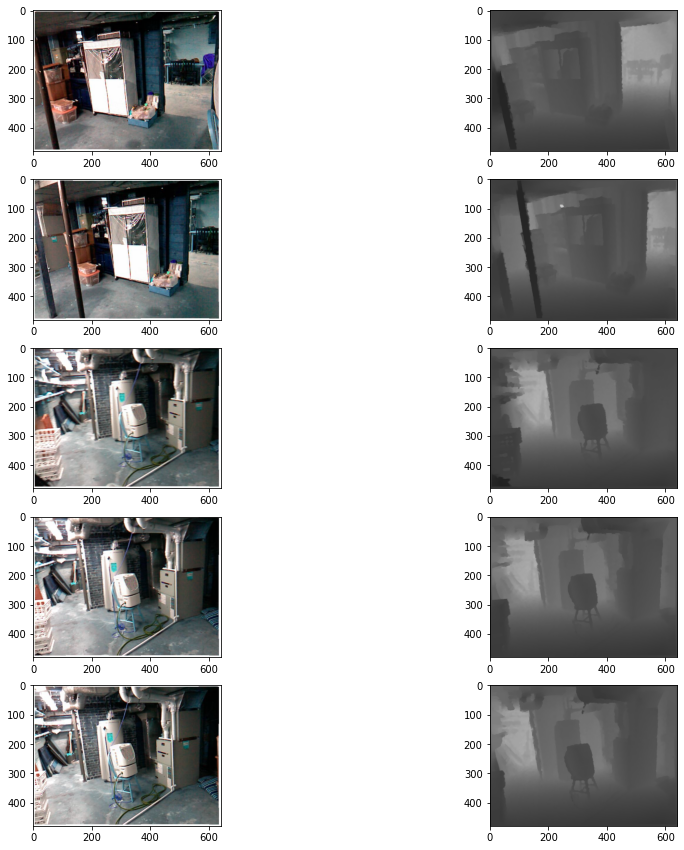

In [ ]:
fig,axes=plt.subplots(nrows=5,ncols=2,figsize=(15,15))

i=0
j=0
x=1
for a,b in labels.items():
  axes[i,j].imshow(cv2.imread(a))
  
  j=1
  x=x+1
  
  axes[i,j].imshow(cv2.imread(b))
  j=0
  
  x=x+1
  i=i+1
  
  if x>=10:
    break

In [ ]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet169

class UpscaleBlock(Model):
    def __init__(self, filters, name):      
        super(UpscaleBlock, self).__init__()
        self.up = UpSampling2D(size=(2, 2), interpolation='bilinear', name=name+'_upsampling2d')
        self.concat = Concatenate(name=name+'_concat') # Skip connection        
        self.convA = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')
        self.reluA = LeakyReLU(alpha=0.2)
        self.convB = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')
        self.reluB = LeakyReLU(alpha=0.2)
    
    def call(self, x):        
        b = self.reluB( self.convB( self.reluA( self.convA( self.concat( [self.up(x[0]), x[1]] ) ) ) ) )
        return b 

class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()                
        self.base_model = DenseNet169(input_shape=(None, None, 3), include_top=False, weights='imagenet')   
        print('Base model loaded {}'.format(DenseNet169.__name__))
        
        # Create encoder model that produce final features along with multiple intermediate features
        outputs = [self.base_model.outputs[-1]]
        for name in ['pool1', 'pool2_pool', 'pool3_pool', 'conv1/relu'] : outputs.append( self.base_model.get_layer(name).output )        
        self.encoder = Model(inputs=self.base_model.inputs, outputs=outputs)
        
    def call(self, x):
        return self.encoder(x)
    
class Decoder(Model):
    def __init__(self, decode_filters):
        super(Decoder, self).__init__()        
        self.conv2 =  Conv2D(filters=decode_filters, kernel_size=1, padding='same', name='conv2')        
        self.up1 = UpscaleBlock(filters=decode_filters//2,  name='up1')
        self.up2 = UpscaleBlock(filters=decode_filters//4,  name='up2')
        self.up3 = UpscaleBlock(filters=decode_filters//8,  name='up3')
        self.up4 = UpscaleBlock(filters=decode_filters//16, name='up4')        
        self.conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')       

    def call(self, features):        
        x, pool1, pool2, pool3, conv1 = features[0], features[1], features[2], features[3], features[4]
        up0 = self.conv2(x)        
        up1 = self.up1([up0, pool3])        
        up2 = self.up2([up1, pool2])        
        up3 = self.up3([up2, pool1])        
        up4 = self.up4([up3, conv1])        
        return self.conv3( up4 )
    


In [ ]:
class conv(layers.Layer) :

    def __init__(self, units, padding = "same", **kwargs) :
        super().__init__(**kwargs)
        
        self.convA = layers.Conv2D(units, (1, 1), (1, 1), padding = padding)
        self.convB = layers.Conv2D(units, (3, 3), (1, 1), padding = padding)
        self.convC = layers.Conv2D(units, (5, 5), (1, 1), padding = padding)
        self.convD = layers.Conv2D(units, (7, 7), (1, 1), padding = padding)
        self.bn2A = layers.BatchNormalization()
        self.bn2B = layers.BatchNormalization()
        self.bn2C = layers.BatchNormalization()
        self.bn2D = layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, input_tensor) :
        d = self.convA(input_tensor)
        x = self.bn2A(d)

        y = self.convB(x)
        y = self.bn2B(y)

        z = self.convC(y)
        z = self.bn2C(z)

        w = self.convD(z)
        w = self.bn2D(w)

        x = tf.identity(x)
        res = self.conc([x, y, z, w])
        return res 

In [ ]:



class conv_2(layers.Layer) :

    def __init__(self, units, padding = "same", **kwargs) :
        super().__init__(**kwargs)
        
        self.convA = layers.Conv2D(units, (1, 1), (1, 1), padding = padding)
        self.convB = layers.Conv2D(units, (1, 1), (1, 1),dilation_rate=2, padding = padding)
        self.convC = layers.Conv2D(units, (1, 1), (1, 1), dilation_rate=4,padding = padding)
        
        self.bn2A = layers.BatchNormalization()
        self.bn2B = layers.BatchNormalization()
        self.bn2C = layers.BatchNormalization()
       
        self.conc = layers.Concatenate()

    def call(self, input_tensor) :
        d = self.convA(input_tensor)
        x = self.bn2A(d)

        y = self.convB(x)
        y = self.bn2B(y)

        z = self.convC(y)
        z = self.bn2C(z)

      

        x = tf.identity(x)
        res = self.conc([x, y, z])
        return res 

In [ ]:
class DepthEstimation(Model) :

    def __init__(self) :
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")

        ## Encoder
        #self.convA = layers.Conv2D(32, (1, 1), (2, 2), padding = "same")
        self.encoder = Encoder()
        self.decoder = Decoder( decode_filters = int(self.encoder.layers[-1].output[0].shape[-1] //2))
        self.Layer2 = conv(16)
        self.Layer3 = conv(32)
        self.Layer4 = conv(64)
        self.Layer5 = conv(64)
        self.Layer6 = conv_2(16)
        self.Layer7 =  conv_2(32)
        self.Layer8 =  conv_2(64)
        self.convC = layers.Conv2D(1, (1, 1), (1, 1))

        ## Decoder
        #self.Layer8 = UpSamplingBlock(640, 14, 14)
        #self.Layer9 = UpSamplingBlock(320, 28, 28)
        #self.Layer10 = UpSamplingBlock(160, 56, 56)
        #self.Layer11 = UpSamplingBlock(80, 112, 112)
        #self.Layer12 = UpSamplingBlock(40, 224, 224)
        #self.convC = layers.Conv2D(1, (1, 1), (1, 1))


    def calculate_loss(self, target, pred) :
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }


    def call(self, input_tensor) :
        
        ## Calling the Encoder Layers
        #x = self.convA(input_tensor)
        x = self.decoder( self.encoder(input_tensor) )
        
        x = self.Layer2(x)
        x = self.Layer3(x)
        x = self.Layer4(x)
        x = self.Layer5(x)
        x = self.Layer6(x)
        x = self.Layer7(x)
        x = self.Layer8(x)
        x = self.convC(x)


       # Calling the Deocder Layers
       # x = self.Layer8(x)
       # x = self.Layer9(x)
       # x = self.Layer10(x)
       # x = self.Layer11(x)
       ## x = self.Layer12(x)
        #x = self.convC(x)
       

        return x




In [ ]:
optimizer = OPT.Adam(
    learning_rate=INIT_LR,
    amsgrad=False,
)
model = DepthEstimation()
# Define the loss function
cross_entropy = losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)
train_loader = DataGenerator(
     data = partition['train'][:100],labels=labels, batch_size=16, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
     data = partition['validation'][:10],labels=labels, batch_size=16, dim=(HEIGHT, WIDTH)
)
model.fit(
    train_loader, epochs=EPOCHS, validation_data = validation_loader
)

Base model loaded DenseNet169
Epoch 1/15
6/6 [==============================] - 393s 57s/step - loss: 1.6141
Epoch 2/15
6/6 [==============================] - 340s 57s/step - loss: 0.7142
Epoch 3/15
2/6 [=========>....................] - ETA: 3:50 - loss: 0.4850

KeyboardInterrupt: ignored

In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
print("jkfnd")

jkfnd
